# Определение перспективного тарифа для телеком компании

**Данные** - <em>данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год</em><br>
**Цель** - <em>сделать предварительный анализ тарифов на небольшой выборке клиентов.</em><br>  Нужно проанализировать поведение клиентов и сделать вывод — какой тарифный план приносит больше доход компании.

**Описание данных**

<em>Таблица users (информация о пользователях):</em>
-	user_id — уникальный идентификатор пользователя
-	first_name — имя пользователя
-	last_name — фамилия пользователя
-	age — возраст пользователя (годы)
-	reg_date — дата подключения тарифа (день, месяц, год)
-	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
-	city — город проживания пользователя
-	tariff — название тарифного плана

<em>Таблица calls (информация о звонках):</em>
-	id — уникальный номер звонка
-	call_date — дата звонка
-	duration — длительность звонка в минутах
-	user_id — идентификатор пользователя, сделавшего звонок

<em>Таблица messages (информация о сообщениях):</em>
-	id — уникальный номер сообщения
-	message_date — дата сообщения
-	user_id — идентификатор пользователя, отправившего сообщение

<em>Таблица internet (информация об интернет-сессиях):</em>
-	id — уникальный номер сессии
-	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
-	session_date — дата интернет-сессии
-	user_id — идентификатор пользователя

<em>Таблица tariffs (информация о тарифах):</em>
-	tariff_name — название тарифа
-	rub_monthly_fee — ежемесячная абонентская плата в рублях
-	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
-	messages_included — количество сообщений в месяц, включённых в абонентскую плату
-	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
-	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
-	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
-	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Оглавление
1. [Загрузка данных и изучение общей информации по проекту](#download-data)
2. [Предобработка данных](#data-preprocessing)
    - [Обработка пустых значений](#processing-empty-values)
    - [Замена типа данных](#data-type-change)
3. [Расчет данных и добавление их в сводную таблицу](#data-counting)
    - [Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам](#сount-calls-number)
    - [Подсчет количества отправленных сообщений по месяцам](#count-sent-messages)
    - [Подсчет объема израсходованного интернет-трафика по месяцам](#count-internet-volume)
    - [Подсчет помесячной выручки с каждого пользователя](#count-monthly-revenue-per-user)
4. [Анализ данных](#data-analysis)
5. [Проверка гипотез](#hypothesis-testing)
    - [Проверяем гипотезу о различии средней выручки пользователей по тарифам «Ультра» и «Смарт»](#revenue-difference-UltravsSmart) 
    - [Проверяем гипотезу о различии средней выручки пользователей из Москвы от выручки пользователей из других регионов](#revenue-difference-Moscowvsregions)
6. [Выводы](#conclusions)

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
Все хорошо, как и прошлый раз.
</div>

## <a id='download-data'><span style="color:black">1. Загрузка данных и изучение общей информации по проекту</span></a>

In [1]:
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st
warnings.filterwarnings("ignore")
# для более удобной работы со таблицами мы уберем ограничение строк и столбцов в отображении
pd.options.display.max_columns = None

In [2]:
def load_data(table, description, index=None):
    data = pd.read_csv(f'datasets/{table}.csv', index_col=index)
    print('==========================================')
    print(f'Таблица {table} ({description})')
    print('==========================================')
    display(data.head(10))
    print('========================================================')
    print(f'Общая информация по датафрейму {table} и всем признакам')
    print('========================================================')
    display(data.info(memory_usage='deep'))
    return(data)

users = load_data('users', 'информация о пользователях')

Таблица users (информация о пользователях)


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Общая информация по датафрейму users и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


None

Таблица с информацией о пользователях состоит из 500 записей и 8 признаков. Обращает на себя внимание следующие моменты: в столбце "churn_date" имеются пустые значения (что предусмотрено условиями), а также в столбце "reg_date" необходимо помянять тип данных на datetime.

In [3]:
calls = load_data('calls', 'информация о звонках')

Таблица calls (информация о звонках)


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Общая информация по датафрейму calls и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


None

Таблица с информацией о звонках состоит из 206607 записей и 4 признаков. В столбце "call_date" необходимо помянять тип данных на datetime, в столбце "duration" нужно округлить вверх значения минут, т.к. у компании "Мегалайн" поминутная тарификация.

In [4]:
messages = load_data('messages', 'информация о сообщениях')

Таблица messages (информация о сообщениях)


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Общая информация по датафрейму messages и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


None

Таблица с информацией о сообщениях состоит из 123036 записей и 3 признаков. В столбце "message_date" необходимо помянять тип данных на datetime.

In [5]:
internet = load_data('internet', 'информация об интернет-сессиях', 'Unnamed: 0')

Таблица internet (информация об интернет-сессиях)


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Общая информация по датафрейму internet и всем признакам
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2 MB


None

Таблица с информацией об интернет-сессиях состоит из 149396 записей и 4 признаков. В столбце "session_date" необходимо помянять тип данных на datetime, в столбце "mb_used" нужно округлить вверх значения мегабайт, т.к. у компании "Мегалайн" помегабайтная тарификация.

In [6]:
tariffs = load_data('tariffs', 'информация о тарифах')

Таблица tariffs (информация о тарифах)


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Общая информация по датафрейму tariffs и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


None

Таблица с информацией о тарифах состоит из 2 записей и 8 признаков.

**Вывод:** Изучение данных позволило выявить ряд недостатков и аномалий, которые необходимо устранить до перехода к анализу:
- таблица с информацией о пользователях  - в столбце "churn_date" имеются пустые значения (что предусмотрено условиями), а также в столбце "reg_date" необходимо помянять тип данных на datetime;
- таблица с информацией о звонках в - столбце "call_date" необходимо помянять тип данных на datetime, в столбце "duration" нужно округлить вверх значения минут, т.к. у компании "Мегалайн" поминутная тарификация;
- таблица с информацией о сообщениях - в столбце "message_date" необходимо помянять тип данных на datetime;
- таблица с информацией об интернет-сессиях - в столбце "session_date" необходимо помянять тип данных на datetime, в столбце "mb_used" нужно округлить вверх значения мегабайт, т.к. у компании "Мегалайн" помегабайтная тарификация.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. С отдельной функцией загрузки придумано хорошо.<br>
2. Поскольку В конце пункта ты указываешь, что есть ряд недостатков и аномалий, то укажи их. Т.к. приходиться прокручивать вврех и сикать их.
</div>

## <a id='data-preprocessing'><span style="color:black">2. Предобработка данных</span></a>

### <a id='processing-empty-values'><span style="color:black">Обработка пустых значений</span></a>

В столбце churn_date таблицы users имеются пропущенные значения. Нужно определить причины, по которым появились пропуски, как наличие пропусков влияет на дальнейший анализ данных, каким образом обработать пропущенные значения.

In [7]:
display(users.sample(10))
display(users[users['churn_date'].isnull() == False].sample(10))
display(users['churn_date'].info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
289,1289,20,NaN,Москва,Таисия,Богданова,2018-09-01,ultra
176,1176,37,NaN,Волгоград,Радим,Куприянов,2018-01-20,smart
177,1177,75,NaN,Новосибирск,Лолита,Аничкина,2018-06-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart
258,1258,52,NaN,Санкт-Петербург,Валерий,Беляев,2018-12-31,smart
308,1308,52,NaN,Москва,Инесса,Корнилова,2018-01-04,smart
272,1272,61,NaN,Пенза,Мстислав,Демьянов,2018-08-29,ultra
475,1475,40,NaN,Новокузнецк,Лидия,Фадеева,2018-01-09,smart
317,1317,45,NaN,Москва,Всеволод,Зыков,2018-07-09,smart
172,1172,40,NaN,Санкт-Петербург,Алан,Карасев,2018-05-05,smart


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
242,1242,39,2018-12-21,Хабаровск,Радим,Федосеев,2018-11-18,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart
392,1392,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra
353,1353,57,2018-11-26,Санкт-Петербург,Доминика,Анищенко,2018-04-22,smart
163,1163,21,2018-12-16,Москва,Лев,Вишневский,2018-11-03,smart
343,1343,30,2018-10-28,Кострома,Анита,Верещагина,2018-08-15,ultra
438,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart


<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: churn_date
Non-Null Count  Dtype 
--------------  ----- 
38 non-null     object
dtypes: object(1)
memory usage: 4.0+ KB


None

В таблице users столбце "churn_date" содержит даты прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), таким образом пустые значения в столбце "churn_date" удалять не нужно, но можно рассмотреть вопрос о том, как использовать данные о прекращении пользования тарифом.

Каждый пользователь имеет свой индификационный номер, поэтому столбцы first_name и last_name можно удалить (такая информация для целей настоящего проекта избыточна), для обеспечения защиты личных данных пользователей.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. В практике, в большинстве случаев ты не получаешь личные данные (имя, фамилия и т.д.), т.к. есть закон и т.д. Поэтому тут скорее всего, не использование меньшего объяма памяти, а речь должна идти о обезличивании данных и соблюдении законов, особенно при передачи их в третьи руки. <br>
2. Кстати, из имен можно было вытащить пол. Сейчас этого делать не надо. Но гендерный признак - значителен и в исследованиях и в машинном обучении.
</div>

In [8]:
users = users.drop(['first_name', 'last_name'], axis=1) 
display(users.head())

,user_id,age,churn_date,city,reg_date,tariff
0,1000,52,NaN,Краснодар,2018-05-25,ultra
1,1001,41,NaN,Москва,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,2018-06-17,smart
3,1003,23,NaN,Москва,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,2018-05-14,ultra


In [9]:
display(calls.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Столбец duration таблицы calls содержит нулевые значения.

In [10]:
display(calls.duration.count())
print(calls[calls["duration"] == 0.0]["duration"].value_counts()[0])

202607

39613


В столбце duration таблицы calls 39613 нулевых значений из 202607 общего количества переменных в столбце. Такие значения могли появиться когда пользователь не дозванился и происходит соединение с голосовой почтой (или без такого соединения). Заполнять такие значения не нужно, так как переменная в дальнейшем будет применена при расчете выручки. Удалять такие значения тоже не нужно, так как переменная будет учитываться при подсчете активности пользователей (количество совершенных звонков).

In [11]:
tables = [users, calls, messages, internet]
for table in tables:
    duplicates = table.duplicated().sum()

if duplicates > 0:
    print(f'Количество дубликатов в таблицах: {table.duplicated().sum()}')
else:
    print('Дубликаты в таблицах не обнаружены')


Дубликаты в таблицах не обнаружены


### <a id='data-type-change'><span style="color:black">Замена типа данных</span></a>

Заменим тип данных на datetime ранее определенных столбцов.

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y/%m/%d")
display(users['reg_date'].info())
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y/%m/%d")
display(calls['call_date'].info())
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y/%m/%d")
display(messages['message_date'].info())
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y/%m/%d")
display(internet['session_date'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: reg_date
Non-Null Count  Dtype         
--------------  -----         
500 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.0 KB


None

<class 'pandas.core.series.Series'>
RangeIndex: 202607 entries, 0 to 202606
Series name: call_date
Non-Null Count   Dtype         
--------------   -----         
202607 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB


None

<class 'pandas.core.series.Series'>
RangeIndex: 123036 entries, 0 to 123035
Series name: message_date
Non-Null Count   Dtype         
--------------   -----         
123036 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 961.3 KB


None

<class 'pandas.core.series.Series'>
Int64Index: 149396 entries, 0 to 149395
Series name: session_date
Non-Null Count   Dtype         
--------------   -----         
149396 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.3 MB


None

**Выводы:** 
- В полученной выборке данных имелись пропущенных значения, которые не влияют на дальнейший анализ. 
- Принято решение не обрабатывать нулевые значения, которые будут применены в дальнейшем при анализе данных. 
- Дубликаты в таблицах не обнаружены.
- В целом данные сформированы качественно, аномалий не имееют, разбиты на несколько таблиц с ключами, что позволяет использовать меньший объем памяти.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. Все нормально.
</div>

## <a id='data-counting'><span style="color:black">3. Расчет данных и добавление их в сводную таблицу.</span></a>

### <a id='сount-calls-number'><span style="color:black">Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам.</span></a>

«Мегалайн» всегда округляет вверх значения минут. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Проверяем предоставленные в датафремах calls данные.

In [13]:
display(calls.head(10))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Как видим данные в столбце duration представлены с точностью до секунды. Для осуществления в дальнейшем расчета месячной выручки произведем округление данных в столбце duration в большую сторону.

In [14]:
calls['duration'] = calls['duration'].apply(np.ceil)
display(calls.head(10))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
9,1000_9,2018-08-15,0.0,1000


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. Ты указывал при загрузке данных, что компания имеет поминутную тарификацию. Не вижу учета этого при расчете длительности звонков в месяц. Аналогично с траффиком. 
</div>

Из данных таблицы calls создадим сводную таблицу, подсчитав по каждому пользователю количество звонков и продолжительность разговоров за каждый месяц. В дальнейшем данную таблицу будем использовать при расчете помесячной выручки по каждому пользователю.

In [15]:
calls_pivot = calls.pivot_table(index=['user_id', calls.call_date.dt.month], values=['duration'], aggfunc=['count', 'sum'])
calls_pivot.columns = ['call_amount', 'total_duration']
calls_pivot.index.names = ['user_id', 'month']
display(calls_pivot.head())

call_amount  total_duration
user_id month                             
1000    5               22           159.0
        6               43           172.0
        7               47           340.0
        8               52           408.0
        9               58           466.0

### <a id='count-sent-messages'><span style="color:black">Подсчет количества отправленных сообщений по месяцам.</span></a>

Из данных таблицы messages создадим сводную таблицу, подсчитав по каждому пользователю количество сообщений за каждый месяц. В дальнейшем данную таблицу также используем при расчете помесячной выручки по каждому пользователю.

In [16]:
messages_pivot = messages.pivot_table(index=['user_id', messages.message_date.dt.month], values=['message_date'], 
                                      aggfunc=['count'])
messages_pivot.columns = ['messages_amount']
messages_pivot.index.names = ['user_id', 'month']
display(messages_pivot.head())

messages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57

### <a id='count-internet-volume'><span style="color:black">Подсчет объема израсходованного интернет-трафика по месяцам.</span></a>

«Мегалайн» всегда округляет вверх значения мегабайт. Проверяем предоставленные в датафремах internet данные.

In [17]:
display(internet.head(10))

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Как видим данные в столбце mb_used необходимо округлить в большую сторону.

In [18]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
display(internet.head(10))

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
5,1000_5,400.0,2018-10-02,1000
6,1000_6,541.0,2018-09-07,1000
7,1000_7,416.0,2018-07-11,1000
8,1000_8,506.0,2018-10-08,1000
9,1000_9,346.0,2018-09-03,1000


Из данных таблицы internet создадим сводную таблицу, подсчитав по каждому пользователю количество мегабай за каждый месяц. В дальнейшем данную таблицу также используем при расчете помесячной выручки по каждому пользователю.

In [19]:
internet_pivot = internet.pivot_table(index=['user_id', internet.session_date.dt.month], values=['mb_used'], aggfunc=['sum'])
internet_pivot.columns = ['mb_amount']
internet_pivot.index.names = ['user_id', 'month']
display(internet_pivot.head())

mb_amount
user_id month           
1000    5         2256.0
        6        23257.0
        7        14016.0
        8        14070.0
        9        14581.0

### <a id='count-monthly-revenue-per-user'><span style="color:black">Подсчет помесячной выручки с каждого пользователя.</span></a>

Соберем ранее созданные сводные таблицы в одну таблицу, добавив информацию о тарифах и горадах пользователей из таблицы users. Столбец tariff переименуем в tariff_name, так такое же название имеет столбец с информацией о тарифах в таблице tariffs. 

In [20]:
user_tariff = users[['user_id', 'tariff', 'city']]
user_tariff.rename(columns = {'tariff': 'tariff_name'}, inplace = True )

summary_table = calls_pivot.merge(messages_pivot, 'left', on = ["user_id", "month"]) \
    .merge(internet_pivot, 'left', on = ["user_id", "month"]) 
summary_table = summary_table.reset_index(drop=False)
summary_table = summary_table.merge(user_tariff, 'outer', on = "user_id")

display(summary_table.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3182 non-null   int64  
 1   month            3174 non-null   float64
 2   call_amount      3174 non-null   float64
 3   total_duration   3174 non-null   float64
 4   messages_amount  2678 non-null   float64
 5   mb_amount        3163 non-null   float64
 6   tariff_name      3182 non-null   object 
 7   city             3182 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 223.7+ KB


None

Как видно имееются столбцы имеющие пустые значения, в том числе столбец month. Отберем строки с пустыми значения чтобы определить причины таких пропусков.

In [21]:
display(summary_table[summary_table['month'].isnull()])

,user_id,month,call_amount,total_duration,messages_amount,mb_amount,tariff_name,city
3174,1091,NaN,NaN,NaN,NaN,NaN,ultra,Набережные Челны
3175,1106,NaN,NaN,NaN,NaN,NaN,ultra,Калуга
3176,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский
3177,1231,NaN,NaN,NaN,NaN,NaN,ultra,Чебоксары
3178,1328,NaN,NaN,NaN,NaN,NaN,ultra,Мурманск
3179,1371,NaN,NaN,NaN,NaN,NaN,smart,Омск
3180,1473,NaN,NaN,NaN,NaN,NaN,ultra,Красноярск
3181,1489,NaN,NaN,NaN,NaN,NaN,smart,Санкт-Петербург


По некоторым пользователем отсутствует информация о совершенных звонках, отправленных сообщениях и используемом интернет-траффике. Скорее всего в таблице users содержится, в том числе информация о пользователях, которые ранее пользовались услугами "Мегалайн", то есть вне рассматриваемого периода. Информацию о таких пользователях нужно удалить, так как при расчетах информация о них применяться не должна.

In [22]:
summary_table.dropna(subset=['month'], inplace=True)
display(summary_table.head(10))
display(summary_table.info())

,user_id,month,call_amount,total_duration,messages_amount,mb_amount,tariff_name,city
0,1000,5.0,22.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,6.0,43.0,172.0,60.0,23257.0,ultra,Краснодар
2,1000,7.0,47.0,340.0,75.0,14016.0,ultra,Краснодар
3,1000,8.0,52.0,408.0,81.0,14070.0,ultra,Краснодар
4,1000,9.0,58.0,466.0,57.0,14581.0,ultra,Краснодар
5,1000,10.0,57.0,350.0,73.0,14717.0,ultra,Краснодар
6,1000,11.0,43.0,338.0,58.0,14768.0,ultra,Краснодар
7,1000,12.0,46.0,333.0,70.0,9827.0,ultra,Краснодар
8,1001,11.0,59.0,430.0,NaN,18452.0,smart,Москва
9,1001,12.0,63.0,414.0,NaN,14053.0,smart,Москва


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3174 non-null   int64  
 1   month            3174 non-null   float64
 2   call_amount      3174 non-null   float64
 3   total_duration   3174 non-null   float64
 4   messages_amount  2678 non-null   float64
 5   mb_amount        3163 non-null   float64
 6   tariff_name      3174 non-null   object 
 7   city             3174 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 223.2+ KB


None

Так как таблица summary_table содержит еще пропущенные значения в столбцах messages_amount и mb_amount (пользователи в отдельные месяцы совершали звонки, но не отправляли сообщения и (или) не пользовались интернетом) заменим их на нулевое значение.

In [23]:
def change_type(col):
    summary_table[col] = summary_table[col].astype('int')
    return col

summary_table.fillna(0, inplace=True)

cols = ['month', 'call_amount', 'total_duration', 'messages_amount', 'mb_amount']
for col in cols:
    change_type(col)
 
display(summary_table.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          3174 non-null   int64 
 1   month            3174 non-null   int32 
 2   call_amount      3174 non-null   int32 
 3   total_duration   3174 non-null   int32 
 4   messages_amount  3174 non-null   int32 
 5   mb_amount        3174 non-null   int32 
 6   tariff_name      3174 non-null   object
 7   city             3174 non-null   object
dtypes: int32(5), int64(1), object(2)
memory usage: 161.2+ KB


None

Создадим еще одну таблицу: в таблицу summary_table добавим данные из таблицы tariffs, чтобы в дальнейшем произвести непосредственно расчет выручки по каждому пользователю.

In [24]:
temporary_table = summary_table.merge(tariffs, how='left', on ="tariff_name")
temporary_table.head(5)

,user_id,month,call_amount,total_duration,messages_amount,mb_amount,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,22,2256,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,43,172,60,23257,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,47,340,75,14016,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,52,408,81,14070,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,58,466,57,14581,ultra,Краснодар,1000,30720,3000,1950,150,1,1


Создадим функцию, которая будет принимать данные из temporary_table и совершать следующие операции: вычитать бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана, а затем прибавим абонентскую плату, соответствующую тарифному плану. Используем функцию для добавления столбца income в таблицу summary_table, который будет содержать информацию о помесячной выручке по каждому пользователю.

In [25]:
def calculation(line):
    
    call_overlimit = line['total_duration'] - line['minutes_included']
    if call_overlimit < 0:
        call_overlimit = 0
    messages_overlimit = line['messages_amount'] - line['messages_included']
    if messages_overlimit < 0:
        messages_overlimit = 0
    mb_overlimit = line['mb_amount'] - line['mb_per_month_included'] 
    if mb_overlimit < 0:
        mb_overlimit = 0
    income = line['rub_monthly_fee'] + call_overlimit * line['rub_per_minute'] \
        + messages_overlimit * line['rub_per_message'] \
        + mb_overlimit / 1024 * line['rub_per_gb']
    return round(income, 2)    
    

summary_table['income'] = temporary_table.apply(calculation, axis=1)
display(summary_table.sample(10))

,user_id,month,call_amount,total_duration,messages_amount,mb_amount,tariff_name,city,income
1339,1211,12,45,330,10,16925,smart,Калуга,855.66
919,1148,7,122,936,20,35158,ultra,Тольятти,2600.10
27,1004,10,29,145,165,18494,ultra,Новокузнецк,1950.00
1403,1223,12,96,651,33,21582,smart,Стерлитамак,2218.23
2776,1435,3,32,215,0,21458,smart,Москва,1741.02
1714,1275,5,55,348,28,18715,smart,Москва,1205.27
460,1072,5,47,342,20,28812,smart,Уфа,3177.34
1483,1238,10,14,98,37,17211,smart,Ростов-на-Дону,911.52
1282,1203,7,72,522,38,3185,ultra,Москва,1950.00
1866,1298,11,70,469,38,19843,smart,Новосибирск,1425.59


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. Указывай, что делаешь и зачем. Нет описания функции, соответственно необходимо разбираться, что она делает. Напиши что и зачем.
</div>

**Выводы:** Использование сводных таблиц (группировки данных) и их объединение позволяет получать дополнительные расчетные данные без объединения исходных данных в большой датафрейм, работа с которым потребовала бы значительное потребление памяти.

## <a id='data-analysis'><span style="color:black">4. Анализ данных.</span></a>

Для удобства работы с данными, относящимися к разным тарифам, создадим отдельные таблицы для тарифа ultra и smart.

In [26]:
ultra = summary_table[summary_table['tariff_name'] == 'ultra']
smart = summary_table[summary_table['tariff_name'] == 'smart']

Для анализа поведения клиентов разных тарифов создатим функцию, которая будет строить гистограммы, боксплоты по каждой выборке и  по учетным параметру: длительности совершенных звонков, количества отправленных сообщений, объема использованного интернет-траффика, объем помесячной выручки. Также функция подсчитает сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц, какой объем выручки получит компания, а также дисперсию и стандартное отклонение по каждому параметру.

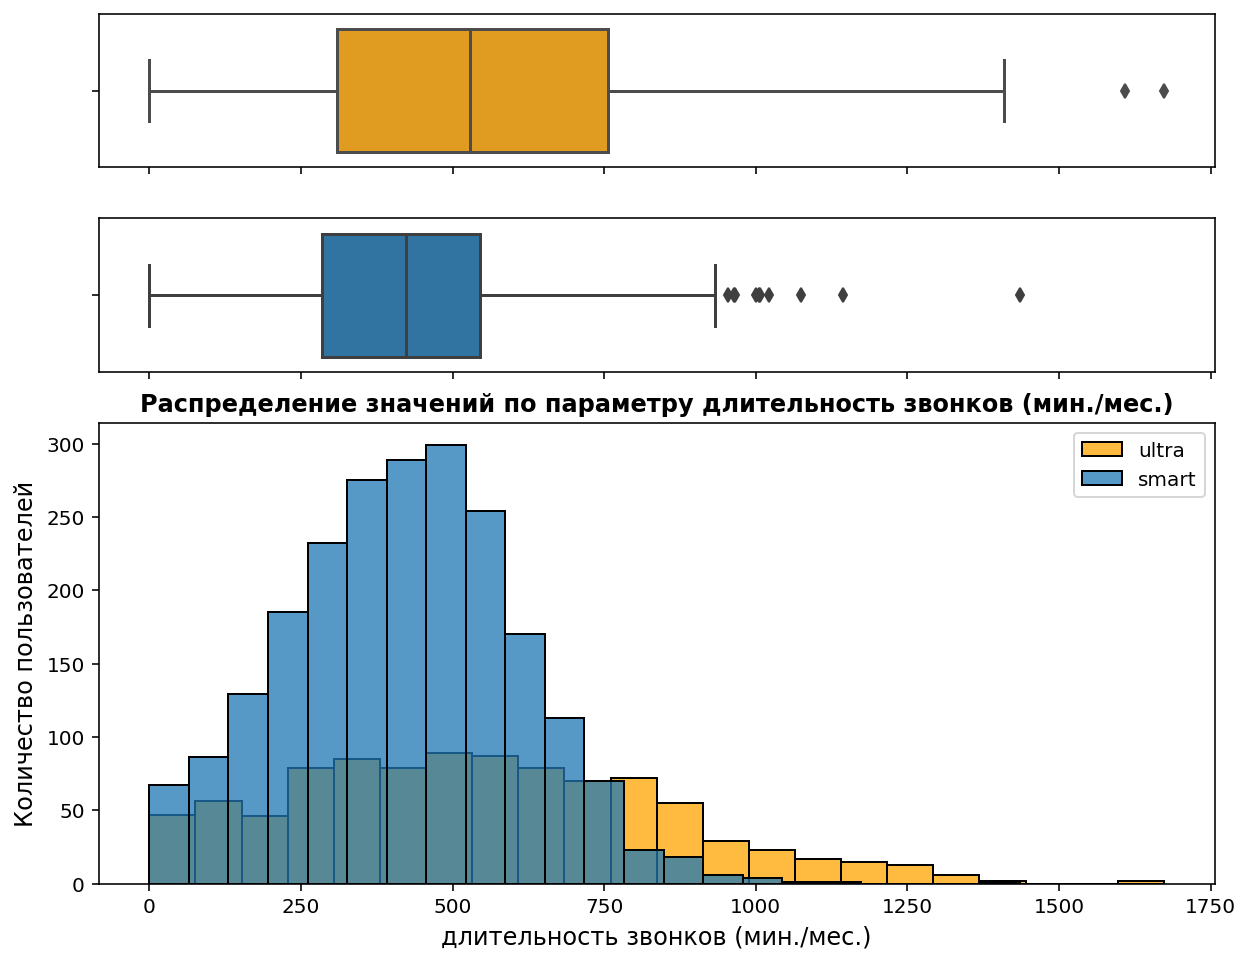

Среднее значение параметра длительность звонков (мин./мес.):
тариф "Ультра" : 545.45
тариф "Смарт" : 419.06
_______________________________________________________________________
Значение дисперсии параметра длительность звонков (мин./мес.):
тариф "Ультра" : 94203.42
тариф "Смарт" : 35844.19
_______________________________________________________________________
Значение стандартного отклонения параметра длительность звонков (мин./мес.):
тариф "Ультра" : 306.93
тариф "Смарт" : 189.33
_______________________________________________________________________


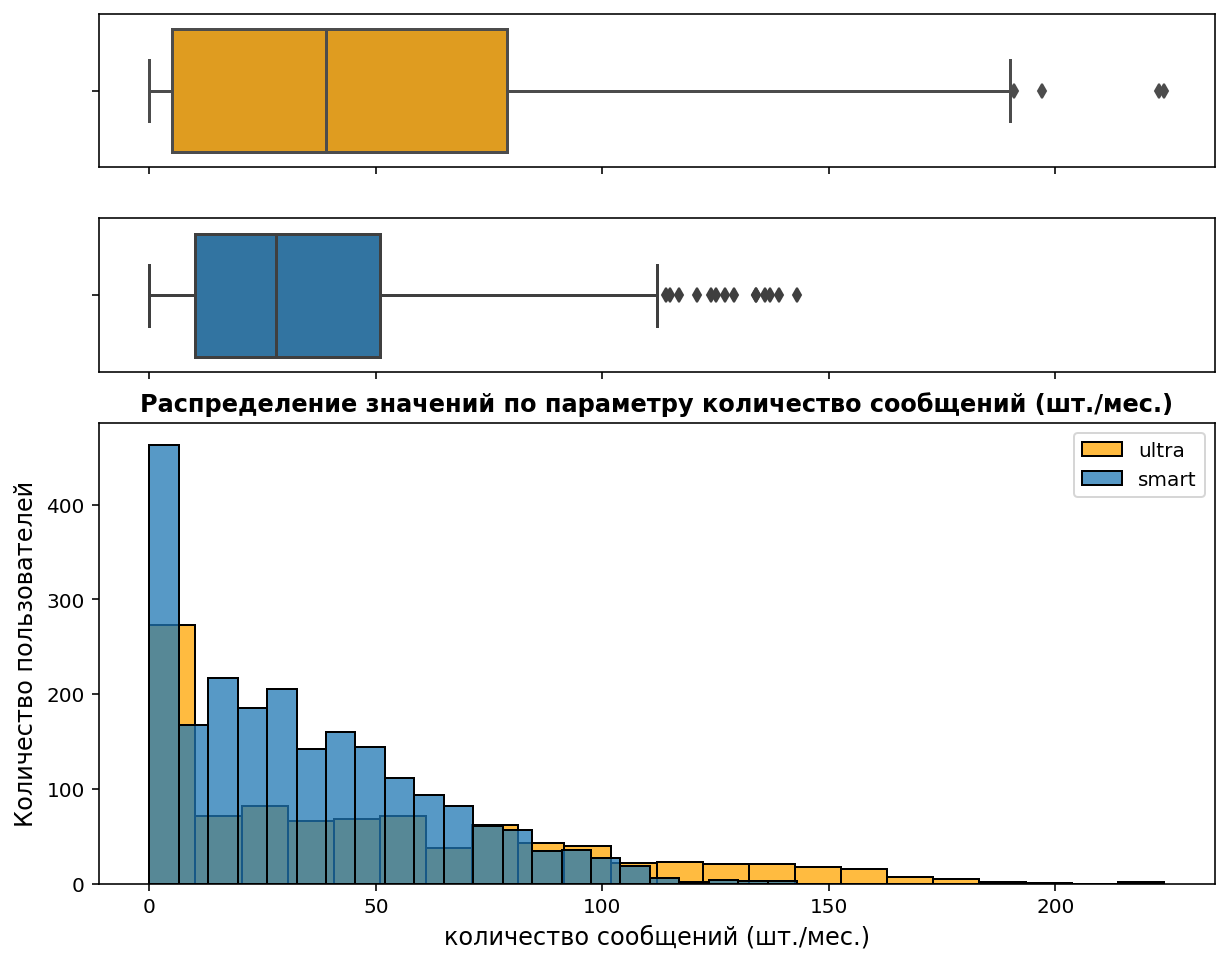

Среднее значение параметра количество сообщений (шт./мес.):
тариф "Ультра" : 49.03
тариф "Смарт" : 33.4
_______________________________________________________________________
Значение дисперсии параметра количество сообщений (шт./мес.):
тариф "Ультра" : 2198.73
тариф "Смарт" : 798.6
_______________________________________________________________________
Значение стандартного отклонения параметра количество сообщений (шт./мес.):
тариф "Ультра" : 46.89
тариф "Смарт" : 28.26
_______________________________________________________________________


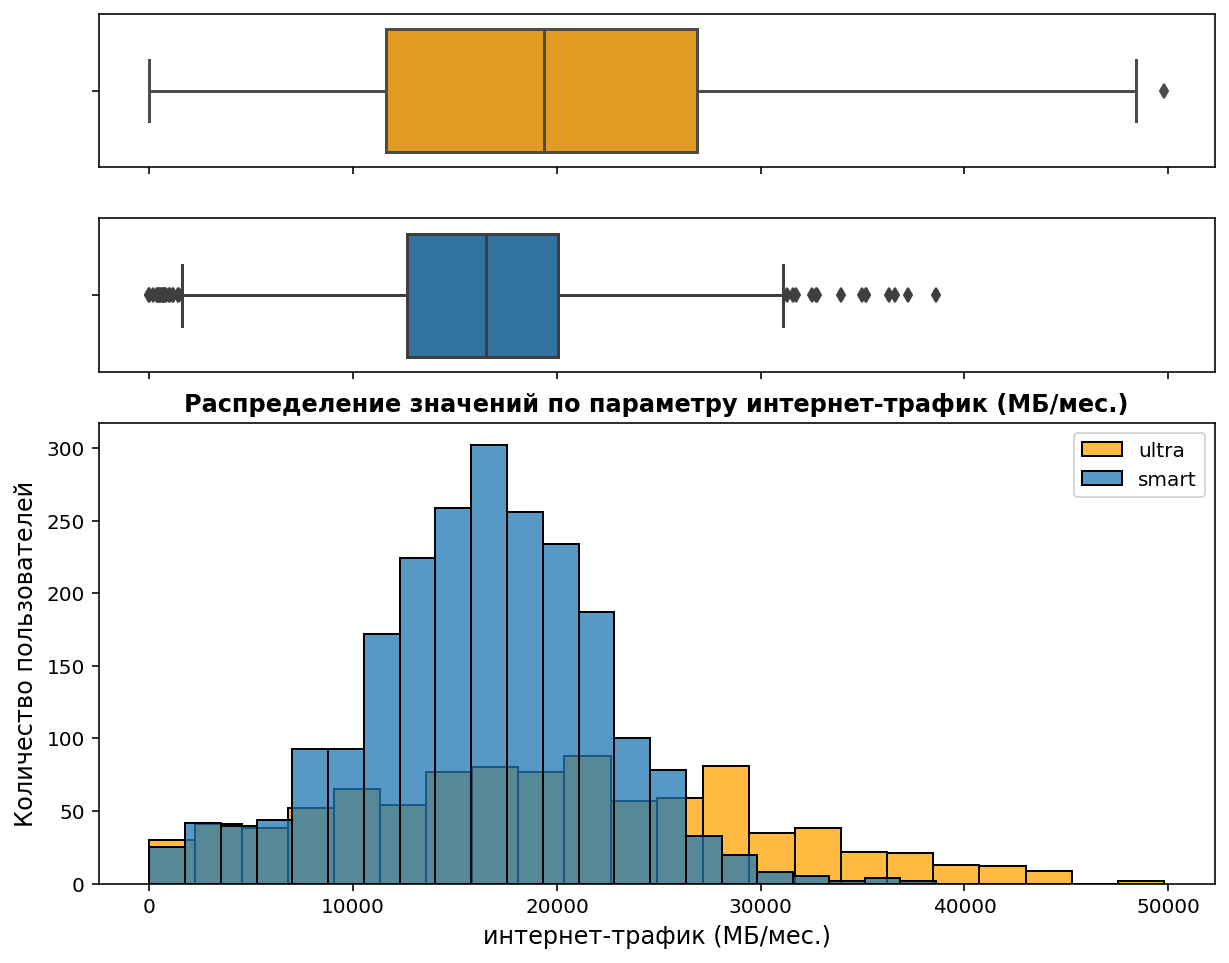

Среднее значение параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 19480.54
тариф "Смарт" : 16230.17
_______________________________________________________________________
Значение дисперсии параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 102737911.08
тариф "Смарт" : 34613960.71
_______________________________________________________________________
Значение стандартного отклонения параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 10135.97
тариф "Смарт" : 5883.36
_______________________________________________________________________


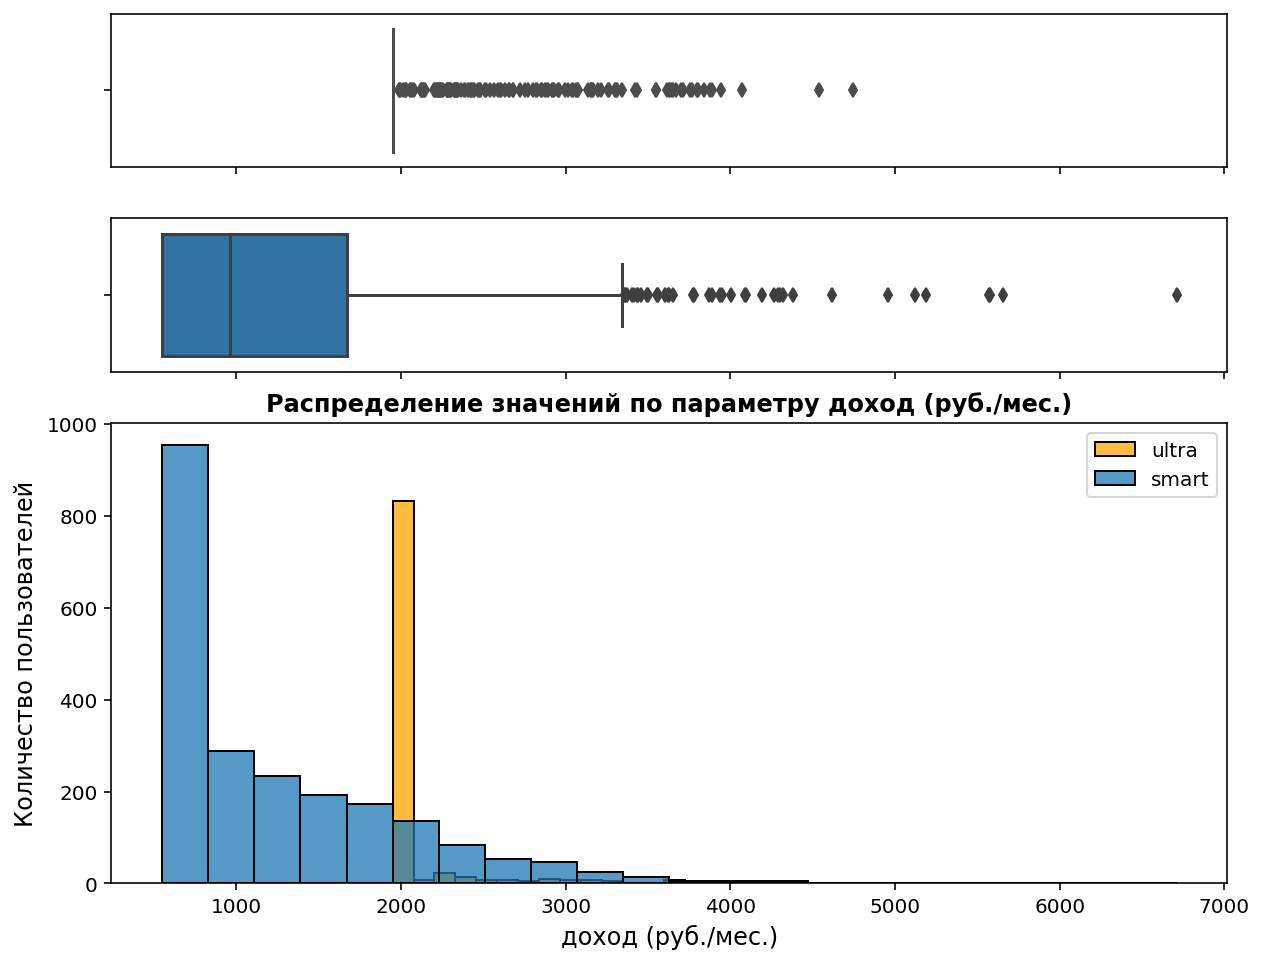

Среднее значение параметра доход (руб./мес.):
тариф "Ультра" : 2061.47
тариф "Смарт" : 1234.29
_______________________________________________________________________
Значение дисперсии параметра доход (руб./мес.):
тариф "Ультра" : 129213.24
тариф "Смарт" : 621581.7
_______________________________________________________________________
Значение стандартного отклонения параметра доход (руб./мес.):
тариф "Ультра" : 359.46
тариф "Смарт" : 788.4
_______________________________________________________________________


In [27]:
def creating_hist(feature, description):
    
    f, (ax_box0, ax_box1, ax_hist) = plt.subplots(3, sharex=True, 
                                                  gridspec_kw={"height_ratios": (.25, .25, .75)}, 
                                                  figsize=(10,8))    

    sns.boxplot(ultra[feature], ax=ax_box0, color='orange')
    sns.boxplot(smart[feature], ax=ax_box1)
    ax_box0.set(xlabel='')
    ax_box1.set(xlabel='')
        
    sns.histplot(data=ultra, x=feature, color='orange', bins=22,  label='Ultra')
    sns.histplot(data=smart, x=feature, bins=22, label='Smart')
    plt.legend(['ultra', 'smart'])
    
    plt.title(f'Распределение значений по параметру {description}',
              fontdict={'fontsize': 12, 'fontweight':'semibold', 'verticalalignment': 'baseline'})
        
    plt.xlabel(description, fontdict={'fontsize': 12}), 
    plt.ylabel('Количество пользователей', fontdict={'fontsize': 12})
    
    plt.show()
    print(f'Среднее значение параметра {description}:')
    print(f'тариф "Ультра" : {round(ultra[feature].mean(), 2)}')
    print(f'тариф "Смарт" : {round(smart[feature].mean(), 2)}')
    print('_______________________________________________________________________')
    print(f'Значение дисперсии параметра {description}:')
    print(f'тариф "Ультра" : {round(np.var(ultra[feature], ddof=1), 2)}')
    print(f'тариф "Смарт" : {round(np.var(smart[feature], ddof=1), 2)}')
    print('_______________________________________________________________________')
    print(f'Значение стандартного отклонения параметра {description}:')
    print(f'тариф "Ультра" : {round(np.std(ultra[feature], ddof=1), 2)}')
    print(f'тариф "Смарт" : {round(np.std(smart[feature], ddof=1), 2)}')
    print('_______________________________________________________________________')
        
features = {'total_duration':'длительность звонков (мин./мес.)', 
            'messages_amount':'количество сообщений (шт./мес.)',
            'mb_amount':'интернет-трафик (МБ/мес.)',
            'income': 'доход (руб./мес.)'}
    
for key, values in features.items():        
    creating_hist(key, values)

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. Аналогично предыдущему замечанию - нет описания функции, соответственно необходимо разбираться, что она делает. Напиши что и зачем.
    
</div>

<em>Построенные графики и произведенные расчеты показывают следующее:</em>

- Тарифный план "Ультра":
распределение значений по параметрам длительность звонков и объем интернет-трафика, стремится к нормальному без значительно выраженных пиков, имеет некоторую скошенность вправо;
распределение значений по тарифному плану "Ультра" имеет более широкий диапазон по сравнению с тарифным планом "Смарт", что показывают не только графики, но более чем в 2 раза большими значениями дисперсии и стандартного отклонения. 

- Тарифный план "Смарт":
распределение значений по параметрам длительность звонков и объем интернет-трафика тарифа, стремится к нормальному, имеет некоторую скошенность влево;
распределение значений по количеству сообщений и выручке нессиметрично, имеют вид распределения Пуассона;
параметры тарифа "Смарт" принимают более высокие значения по сравнению с тарифом "Ультра", имеют явно выраженные пики, которые приходятся на размеры параметров, включенные в тарифный план.

**Выводы:** Наблюдение за параметрами тарифа "Смарт" показывает, что большинство из них принимают более высокие значения по сравнению с тарифом "Ультра". При этом диапазон, на котором появляются значения, более широкий по тарифу "Ультра". 

Значительному количеству пользователей тарифа "Смарт" не хватает бесплатных минут и интернет-трафика, включенных в тариф (среднее значение и медианна, близки к лимиту). Пользователи тарифа "Ультра" в основном достаточно количества минут и мегабайт, включенных в тарифный план.

Медианное значение параметра "Доход в месяц" по тарифному плану "Ультра", больше чем по тарифному плану "Смарт", но по тарифному плану "Смарт" наблюдается почти в 2 раза больший разброс. Межквартильный размаз по доходам по по тарифному плану "Смарт" также значительно выше, что свидетельствует, что пользователи не ограничиваются установленными тарифным планом лимитами по количеству бесплатных минут и мегабайт интернет-трафика. Это позволяет сделать вывод о том, что тарифный план с меньшей абонентской платой и меньшим количеством бесплатных может быть более привлекательнее для пользователей, но и позволяет получать значительно больше дохода за счет потребления пользователем предоставляемых услуг сверх установленной абонентской платы.

## <a id='hypothesis-testing'><span style="color:black">5. Проверка гипотез.</span></a>

### <a id='revenue-difference-UltravsSmart'><span style="color:black">Проверяем гипотезу о различии средней выручки пользователей по тарифам "Ультра" и "Смарт".</span></a>

Нулевая гипотеза - средняя выручка по тарифам "Ультра" и "Смарт" не различается.
Альтернативная гипотеза - средняя выручка по тарифам "Ультра" и "Смарт" различается.

Для проверки гипотезы применим двухвыборочный критерий Стьюдента, основанный на предположении, что выборки получены из генеральных совокупностей, имеющих приближенно нормальное распраделение и не взаимосвязанных друг с другом. Для реализации используем метод scipy.stats.ttest_ind библиотеки scipy. 

In [28]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(ultra['income'], smart['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4081556659852518e-184
Отвергаем нулевую гипотезу


Исходя из полученных результатов есть основания отвергнуть нулевую гипотезу в пользу альтернативной.


### <a id='revenue-difference-Moscowvsregions'><span style="color:black">Проверяем гипотезу о различии средней выручки пользователей из Москвы от выручки пользователей из других регионов.</span></a>

Нулевая гипотеза - средняя выручка пользователей из Москвы и пользователей из регионов не различается. Альтернативная гипотеза - средняя выручка пользователей из Москвы и пользователей из регионов различается.

In [29]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(summary_table[summary_table['city'] == 'Москва']['income'], 
                       summary_table[summary_table['city'] != 'Москва']['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.393324227019597
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью в почти 39% такое различие можно получить случайно. Нет оснований отвергнуть нулевую гипотезу в пользу альтернативыи.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий </h1>
1. Проверь с учетом пересчитанных значений.
</div>

## <a id='conclusions'><span style="color:black">6. Выводы.</span></a>

Анализ тарифных планов компании "Мегалайн" позволяет сделать следующие выводы:

- Наблюдение за параметрами тарифа "Смарт" показывает, что большинство из них принимают более высокие значения по сравнению с тарифом "Ультра". При этом диапазон, на котором появляются значения, более широкий по тарифу "Ультра". 

- Значительному количеству пользователей тарифа "Смарт" не хватает бесплатных минут и интернет-трафика, включенных в тариф (среднее значение и медианна, близки к лимиту). Пользователи тарифа "Ультра" в основном достаточно количества минут и мегабайт, включенных в тарифный план.

- Медианное значение параметра "Доход в месяц" по тарифному плану "Ультра", больше чем по тарифному плану "Смарт", но по тарифному плану "Смарт" наблюдается почти в 2 раза больший разброс. Межквартильный размаз по доходам по по тарифному плану "Смарт" также значительно выше, что свидетельствует, что пользователи не ограничиваются установленными тарифным планом лимитами по количеству бесплатных минут и мегабайт интернет-трафика. Это позволяет сделать вывод о том, что тарифный план с меньшей абонентской платой и меньшим количеством бесплатных может быть не только более привлекательным для пользователей, но и позволяет  телеком компании получать значительно больше дохода за счет потребления пользователями предоставляемых услуг сверх установленной абонентской платы.
 
- Исходя из полученных результатов проверки гипотезы есть основания отвергнуть нулевую гипотезу о том, что средняя выручка по тарифам "Ультра" и "Смарт" одинаковая.

- Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью в почти 39% такое различие можно получить случайно. Нет оснований отвергнуть нулевую гипотезу в пользу альтернативыи.

Исходя из полученных данных, можно сделать вывод о том, что коммерческому отделу компании "Мегалайн" необходимо скорректировать рекламный бюджет с целью привленичения большего количества пользователей тарифного плана "Смарт". Пользователи тарифного плана "Ультра" хоть и платят большую абонентскую плату, но при этом расчитывают на включенные в тарифный планы бесплатные минуты, сообщения и количества мегабайт. Такие пользователи скорее всего умеют считать свои деньги и с большой вероятностью сами узнают информацию о тарифном плане, который удовлетворяет их потребности.  